In [1]:
import paddle
import os
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from paddle.io import Dataset
from paddle.vision import transforms
import paddle.vision as vision
from paddle import nn
import paddle.nn.functional as F
paddle.set_device('gpu:0')
paddle.__version__

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


'2.3.2'

In [2]:
cd data/data60/

/home/aistudio/data/data60


In [3]:
# 解压数据集
!unzip -o test.zip
!unzip -o training.zip

Archive:  test.zip
  inflating: test.csv                
Archive:  training.zip
  inflating: training.csv            


In [4]:
train_dir = "./training.csv"
test_dir = './test.csv'
lookid_dir = "./IdLookupTable.csv"

In [5]:
data_visualization = pd.read_csv('training.csv').dropna(how='any').reindex()
data_visualization.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


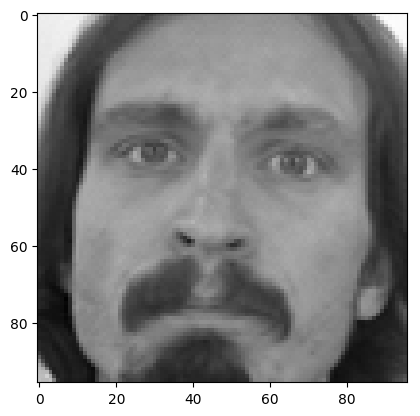

In [6]:
img = np.array(data_visualization["Image"][0].split(' '), dtype='int').reshape(96, 96).repeat(3, axis=1).reshape(96, 96, 3)
plt.imshow(img)

In [7]:
class ImageTransfroms:
    """
    (96, 96) --> (96, 96, 3) --> (3, 96, 96)
    """
    def __init__(self, fmt):
        self.format = fmt
    
    def __call__(self, img):
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=2)
        img = img.transpose(self.format)

        if img.shape[0] == 1:
            img = np.repeat(img, 3, axis=0)
        return img

class FaceDataset(Dataset):
    def __init__(self, data_path, mode='train', val_split=0.2):
        super(FaceDataset, self).__init__()
        self.mode = mode
        assert self.mode in ['train', 'test', 'val'], f"mode should be 'train' or 'val' or 'test',  but got{self.mode}"
        self.data_source = pd.read_csv(data_path)
        # eliminate unlabeled samples
        self.data_source.dropna(how='any', inplace=True)
        self.data_label_all = self.data_source.drop("Image", axis=1)
        
        # divide training set and test set
        if self.mode in ['train', 'val']:
            np.random.seed(43)
            data_len = len(self.data_source)
            # divide randomly
            shuffled_indices = np.random.permutation(data_len)
            self.shuffled_indices = shuffled_indices
            val_set_size = int(data_len * val_split)
            if self.mode == 'val':
                val_indices = shuffled_indices[:val_set_size]
                self.data_img = self.data_source.reindex().iloc[val_indices]
                self.data_label = self.data_label_all.reindex().iloc[val_indices]
            elif self.mode == 'train':
                train_indices = shuffled_indices[val_set_size:]
                self.data_img = self.data_source.reindex().iloc[train_indices]
                self.data_label = self.data_label_all.reindex().iloc[train_indices]
        elif self.mode == 'test':
            self.data_img = self.data_source
            self.data_label = self.data_label_all
        
        self.transforms = transforms.Compose(
            [ImageTransfroms((2, 0, 1)) # (C, W, H)
        ])

    def __getitem__(self, idx):
        img = self.data_img['Image'].iloc[idx].split(' ')
        img = ['0' if x == '' else x for x in img]
        img = np.array(img, dtype='float32').reshape(96, 96)
        img = self.transforms(img)
        label = np.array(self.data_label.iloc[idx, :], dtype='float32') / 96 # scale to [0, 1]
        return img, label
    
    def __len__(self):
        return len(self.data_img)

In [8]:
train_dataset = FaceDataset(train_dir, mode='train')
val_dataset = FaceDataset(train_dir, mode='val')
test_dataset = FaceDataset(test_dir, mode='test')

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


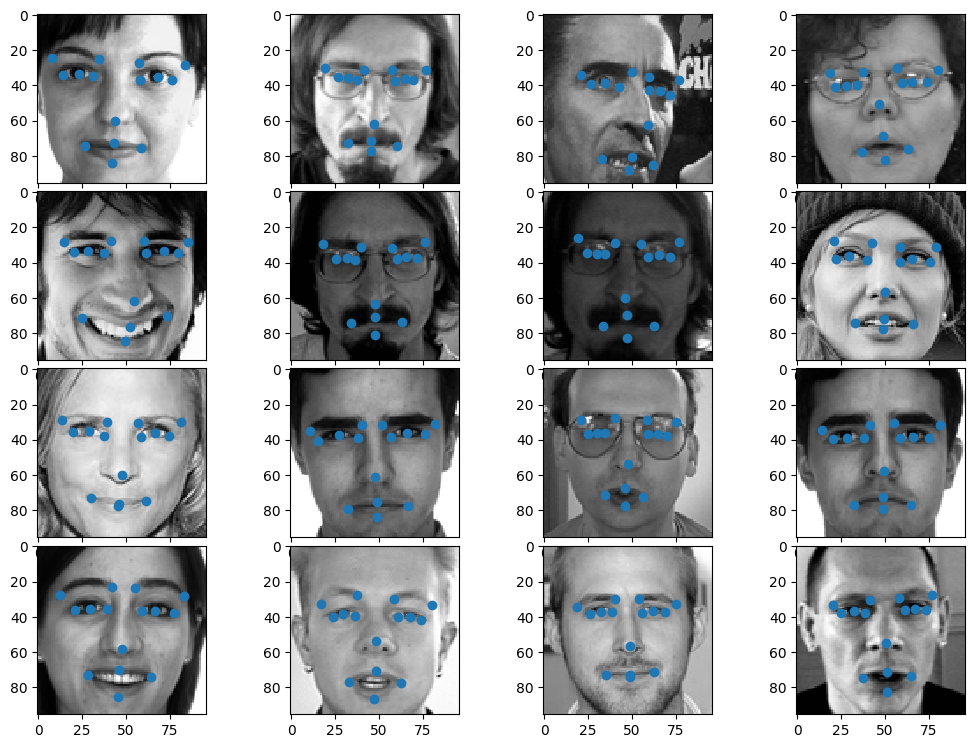

In [9]:
# sampling to show from dataset
fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(16):
    axis = fig.add_subplot(4, 4, i + 1)
    idx = np.random.randint(len(train_dataset))
    axis.imshow(train_dataset[idx][0][0], cmap='gray')
    axis.scatter(train_dataset[idx][1][0::2] * 96, train_dataset[idx][1][1::2] * 96)

In [10]:
# define model
class FaceNet(nn.Layer):
    def __init__(self, num_keypoints, pretrained=False):
        super(FaceNet, self).__init__()
        self.backbone = vision.models.resnet18(pretrained)
        self.outlayer1 = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout((0.1)),
        )
        self.outlayer2 = nn.Linear(512, num_keypoints*2)
    
    def forward(self, x):
        out = self.outlayer2(self.outlayer1(self.backbone(x)))
        return out

In [11]:
from paddle.static import InputSpec

num_keypoints = 15
model = paddle.Model(FaceNet(num_keypoints=num_keypoints))
model.summary(InputSpec((1, 3, 96, 96)))

W1008 00:18:08.648859   355 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W1008 00:18:08.652033   355 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-1         [[1, 3, 96, 96]]     [1, 64, 48, 48]         9,408     
   BatchNorm2D-1     [[1, 64, 48, 48]]     [1, 64, 48, 48]          256      
      ReLU-1         [[1, 64, 48, 48]]     [1, 64, 48, 48]           0       
    MaxPool2D-1      [[1, 64, 48, 48]]     [1, 64, 24, 24]           0       
     Conv2D-2        [[1, 64, 24, 24]]     [1, 64, 24, 24]        36,864     
   BatchNorm2D-2     [[1, 64, 24, 24]]     [1, 64, 24, 24]          256      
      ReLU-2         [[1, 64, 24, 24]]     [1, 64, 24, 24]           0       
     Conv2D-3        [[1, 64, 24, 24]]     [1, 64, 24, 24]        36,864     
   BatchNorm2D-3     [[1, 64, 24, 24]]     [1, 64, 24, 24]          256      
   BasicBlock-1      [[1, 64, 24, 24]]     [1, 64, 24, 24]           0       
     Conv2D-4        [[1, 64, 24, 24]]     [1, 64, 24, 24]    

{'total_params': 12227014, 'trainable_params': 12207814}

In [12]:
# train the model 
optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
model.prepare(optim, paddle.nn.MSELoss())
model.fit(train_dataset, val_dataset, epochs=60, batch_size=256)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/60


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:654: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


step 7/7 - loss: 0.1107 - 651ms/step
Eval begin...
step 2/2 - loss: 1.7366 - 481ms/step
Eval samples: 428
Epoch 2/60
step 7/7 - loss: 0.0488 - 575ms/step
Eval begin...
step 2/2 - loss: 0.1378 - 480ms/step
Eval samples: 428
Epoch 3/60
step 7/7 - loss: 0.0365 - 575ms/step
Eval begin...
step 2/2 - loss: 0.0649 - 473ms/step
Eval samples: 428
Epoch 4/60
step 7/7 - loss: 0.0265 - 582ms/step
Eval begin...
step 2/2 - loss: 0.0152 - 478ms/step
Eval samples: 428
Epoch 5/60
step 7/7 - loss: 0.0231 - 583ms/step
Eval begin...
step 2/2 - loss: 0.0040 - 487ms/step
Eval samples: 428
Epoch 6/60
step 7/7 - loss: 0.0165 - 585ms/step
Eval begin...
step 2/2 - loss: 0.0040 - 487ms/step
Eval samples: 428
Epoch 7/60
step 7/7 - loss: 0.0149 - 555ms/step
Eval begin...
step 2/2 - loss: 0.0020 - 455ms/step
Eval samples: 428
Epoch 8/60
step 7/7 - loss: 0.0121 - 557ms/step
Eval begin...
step 2/2 - loss: 0.0019 - 459ms/step
Eval samples: 428
Epoch 9/60
step 7/7 - loss: 0.0102 - 563ms/step
Eval begin...
step 2/2 - lo

In [13]:
predict = model.predict(test_dataset)

Predict begin...
step 1783/1783 [==============================] - 13ms/step          
Predict samples: 1783


In [14]:
val_perdict = model.predict(val_dataset)

Predict begin...
step 428/428 [==============================] - 12ms/step          
Predict samples: 428


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


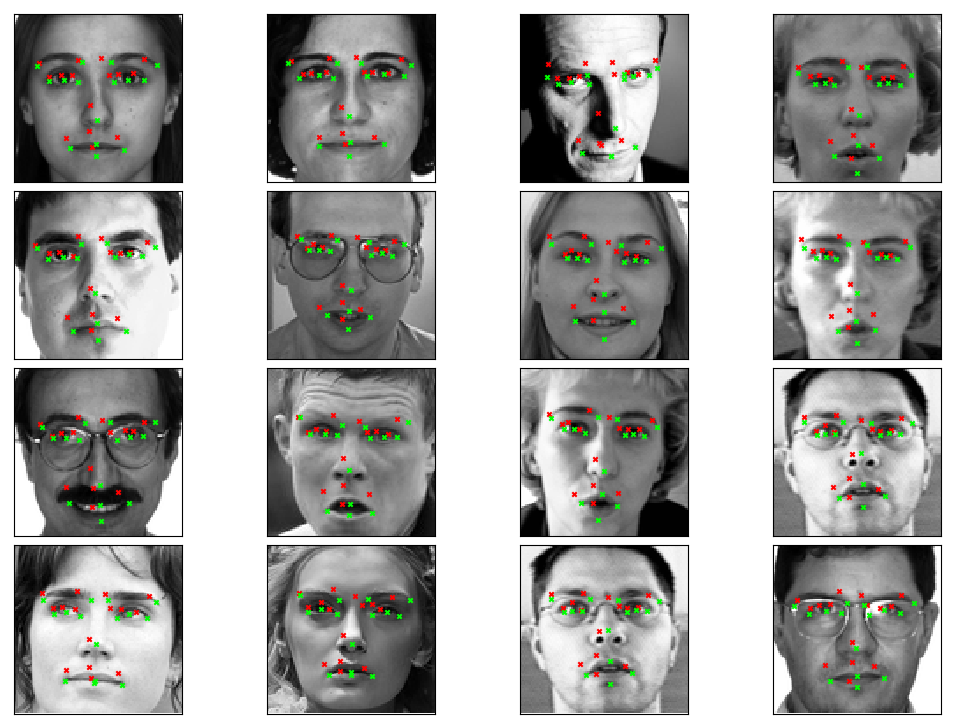

In [15]:
def plot_sample(x, y, axis, gt=[]):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='x', s=10, color='r')
    if gt!=[]:
        axis.scatter(gt[0::2], gt[1::2], marker='x', s=10, color='lime')


fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    idx = np.random.randint(val_dataset.__len__())
    img, gt_label = val_dataset[idx]
    gt_label = gt_label*96
    label_pred = val_perdict[0][idx].reshape(-1)
    label_pred = label_pred*96
    plot_sample(img[0], label_pred, axis, gt_label)
plt.show()

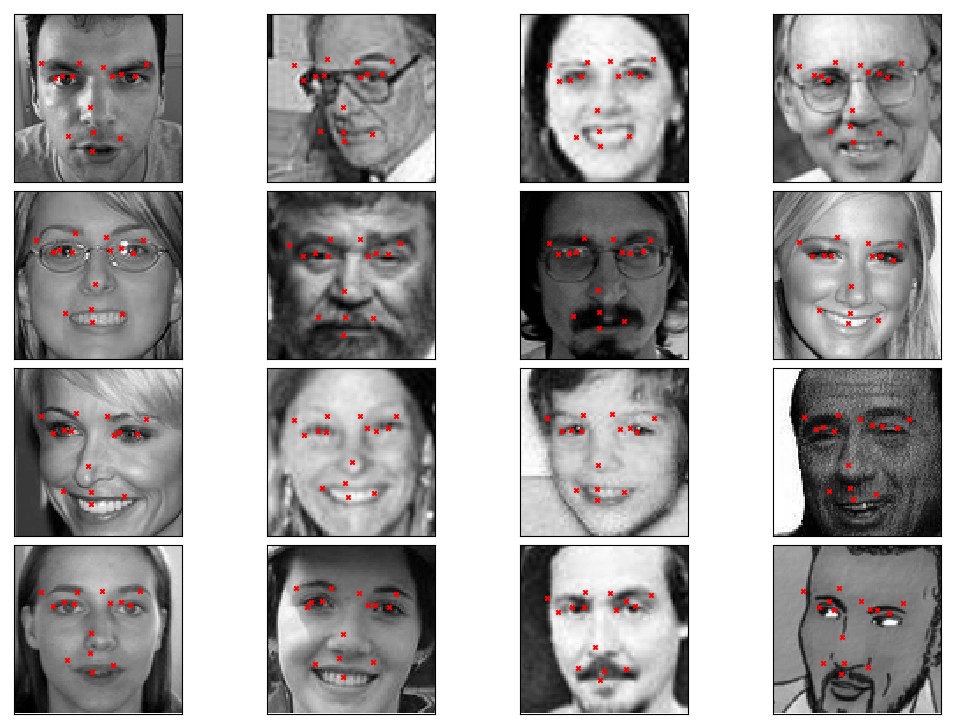

In [16]:
fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    idx = np.random.randint(test_dataset.__len__())
    img, _ = test_dataset[idx]
    label_pred = predict[0][idx].reshape(-1)
    label_pred = label_pred*96
    plot_sample(img[0], label_pred, axis)
plt.show()